# Density Estimation in 1-dimensional Setting

This Jupyter notebook demonstrates how to use functions in `dekef` to estimate probability density functions in a kernel exponential family using the score matching loss function and the negative log-likelihood loss function, and visualize the resulting density estimates in the 1-dimensional setting. 

The dataset used here is the eruption data from the Old Faithful geyser in Yellowstone National Park in Wyoming and was first published by [Azzalini and Bowman (1990)](https://www.jstor.org/stable/2347385?seq=1). This dataset consists of 299 observations collected continuously from August 1, 1985 to August 15, 1985, and contain 2 variables, namely, the `eruption` variable (the duration of this eruption) and the `waiting` variable (the waiting time for this eruption). Both variables are measured in the unit of minute. 

For the illustrative purpose, we focus on the `waiting` variable only. 

We first import the modules needed. 

In [1]:
import os
import numpy as np
import pandas as pd

from dekef.base_density import *
from dekef.kernel_function import *
from dekef.data_median_dist import *

from dekef.negloglik_gubasis import *
from dekef.negloglik_scorematchingbasis import *

from dekef.scorematching_common_functions import *
from dekef.scorematching_loss_function import *
from dekef.scorematching_penalized import *
from dekef.scorematching_earlystopping import *

from dekef.plot_density_1d import *

from IPython.display import Markdown as md

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

## Load the data

We now load the data in the following cell. 

In [2]:
os.chdir('../data')
true_data = np.load('geyser.npy').astype(np.float64)
waiting = true_data[:, 0].reshape(-1, 1)

We look at the histogram of the `waiting` variable. 

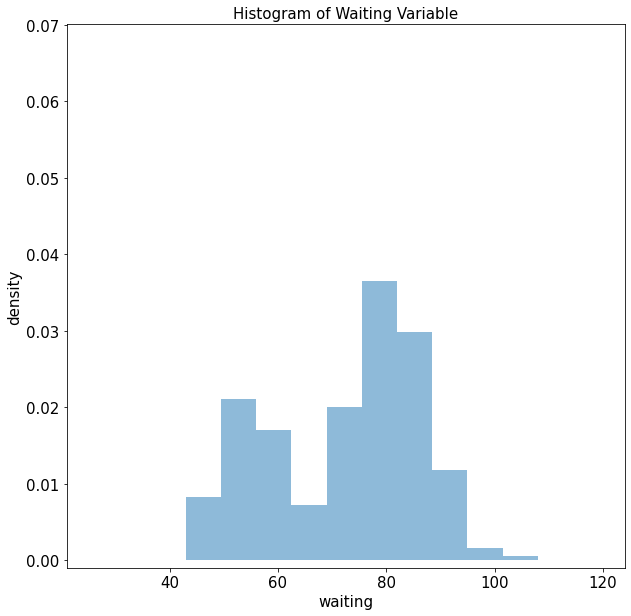

In [3]:
# set plot parameters
font_size = 15
xlimit = (21., 124.)
ylimit = (-0.001, 0.0701)

# plot the histogram of waiting variable 
ax = pd.Series(waiting.flatten()).hist(grid = False, figsize = (10, 10), bins = 'fd', density = True, alpha = 0.5)
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.set_title('Histogram of Waiting Variable', fontsize = font_size)
ax.set_xlabel('waiting', fontsize = font_size)
ax.set_ylabel('density', fontsize = font_size)
ax.tick_params(axis = 'both', labelsize = font_size)

We choose the kernel function in the kernel exponential family to be the Gaussian kernel whose bandwidth is equal to $0.4$ times the median of pairwise distances of data. The median of pairwise distances of data can be computed using the `data_median_dist` function. 

In [4]:
bw_coef = 0.4
med_dist = data_median_dist(waiting.reshape(-1, 1))
bw = bw_coef * med_dist
kernel_function = GaussianPoly2(
    data = waiting, 
    r1 = 1.0, 
    r2 = 0., 
    c = 0., 
    bw = bw_coef * med_dist)

We choose the base density in the kernel exponential family to be the probability density function of the Gamma distribution whose parameters are estimated by the method of the maximum likelihood. 

In [5]:
base_density = BasedenGamma(waiting, 36, 2)

## Penalized Score Matching Density Estimation

We now demonstrate how to estimate density functions using the [penalized score matching density estimation method](https://www.jmlr.org/papers/v18/16-011.html) at a single penalty parameter $\lambda > 0$. The main function that achieves this is the `coef` function in the class `ScoreMatchingPenalized`, which yields the coefficients of basis functions of the natural parameter. 

In [6]:
sm_pen = ScoreMatchingPenalized(
    data = waiting, 
    base_density = base_density,
    kernel_type = 'gaussian_poly2', 
    kernel_r1 = 1.0, 
    kernel_r2 = 0.0, 
    kernel_c = 0.0, 
    kernel_bw = bw)

In [7]:
# Here, we choose the penalty parameter to be exp(-10.0), supplied using the lambda_param argument. 
coef_smpen = sm_pen.coef(
    data = waiting, 
    lambda_param = np.exp(-10.0))

Next, we visualize the resulting score matching density estimate together with the histogram. The main function that achieves this is `plot_density_1d`. Besides exhibiting the plot of the density estimate, this function also returns the points at which the density values are estimated and plotted and the resulting estimates. 

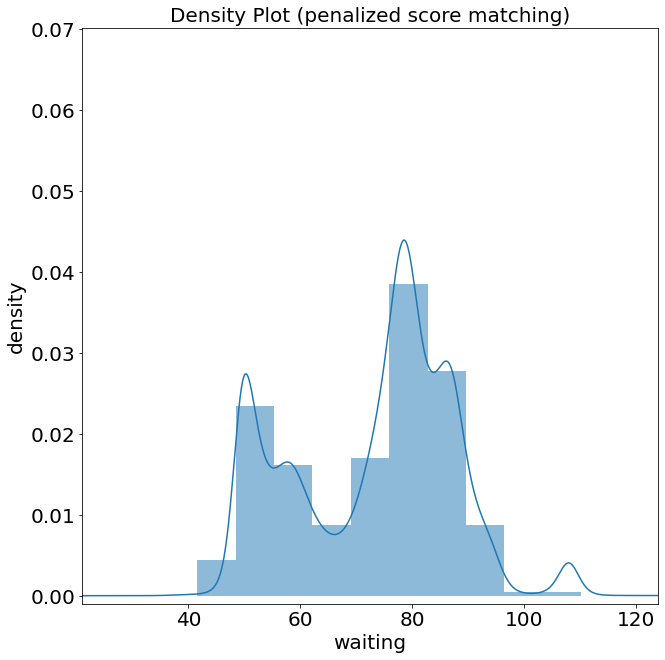

In [8]:
# specify the plotting parameters 
plot_params = plot_density_1d_params(xlimit, ylimit, )

# visualize density estimate
den_vals = plot_density_1d(
    data = waiting, 
    kernel_function = kernel_function, 
    base_density = base_density, 
    basis_type = 'smbasis', 
    coef = coef_smpen, 
    normalizing = True, 
    method = 'penalized score matching', 
    x_label = 'waiting',
    grid_points = None,
    save_plot = False, 
    save_dir = None, 
    save_filename = None, 
    plot_kwargs = plot_params)

It is typical that the best penalty parameter $\lambda > 0$ is unknown. With a list of candidates of penalty parameters, we can use the [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#:~:text=Cross%2Dvalidation%2C%20sometimes%20called%20rotation,to%20an%20independent%20data%20set.) to select the best one. The main function that achieves this is `optlambda` in the class `ScoreMatchingPenalized`, which returns the optimal penalty parameter and the corresponding coefficient vector of basis functions in the natural parameter. 

In [9]:
opt_smpen = sm_pen.optlambda(
    lambda_cand = np.exp(np.linspace(-10.0, -2.0, 9)), 
    k_folds = 5,
    save_dir = None, 
    save_info = False)

Lambda 0: 4.5399929762484854e-05
Lambda 1: 0.00012340980408667956
Lambda 2: 0.00033546262790251185
Lambda 3: 0.0009118819655545162
Lambda 4: 0.0024787521766663585
Lambda 5: 0.006737946999085467
Lambda 6: 0.01831563888873418
Lambda 7: 0.049787068367863944
Lambda 8: 0.1353352832366127
The cross validation scores are:
{5e-05: 0.008408486, 0.00012: -0.0019024704, 0.00034: -0.0061861741, 0.00091: -0.0074377248, 0.00248: -0.0069140888, 0.00674: -0.0050017017, 0.01832: -0.002751667, 0.04979: -0.0012323226, 0.13534: -0.0004927869}
The optimal penalty parameter is 0.0009118819655545162.
Final run with the optimal lambda.


The optimal parameter is {{np.format_float_scientific(x = opt_smpen['opt_lambda'], precision = 5)}} whose logarithm is {{np.log(opt_smpen['opt_lambda'])}}. We now plot the corresponding density estimate below.

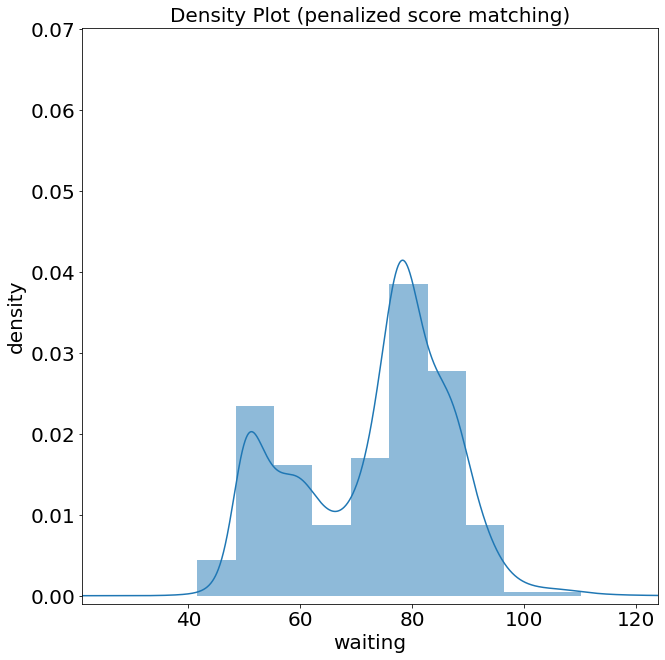

In [10]:
# visualize the optimal density estimate
den_vals = plot_density_1d(
    data = waiting, 
    kernel_function = kernel_function, 
    base_density = base_density, 
    basis_type = 'smbasis', 
    coef = opt_smpen['opt_coef'], 
    normalizing = True, 
    method = 'penalized score matching', 
    x_label = 'waiting',
    grid_points = None,
    save_plot = False, 
    save_dir = None, 
    save_filename = None, 
    plot_kwargs = plot_params)

## Early Stopping Score Matching Density Estimation

We now demonstrate how to estimate density functions using the early stopping score matching density estimation method at an arbitrary number of iterations in the gradient descent algorithm. The main function that achieves this is `coef` in the class `ScoreMatchingEarlyStopping`, which yields the coefficients of basis functions in the natural parameter. 

In [11]:
# Here, we choose the number of iterations to be 200, supplied using the iter_num argument. 
sm_earlystop = ScoreMatchingEarlyStopping(
    data = waiting, 
    base_density = base_density,
    kernel_type = 'gaussian_poly2', 
    kernel_r1 = 1.0, 
    kernel_r2 = 0.0, 
    kernel_c = 0.0, 
    kernel_bw = bw)

In [12]:
coef_smes = sm_earlystop.coef(
    data = waiting, 
    iter_num = 200, 
    step_size = 20)

We now plot the resulting density estimate using the `plot_density_1d` function.

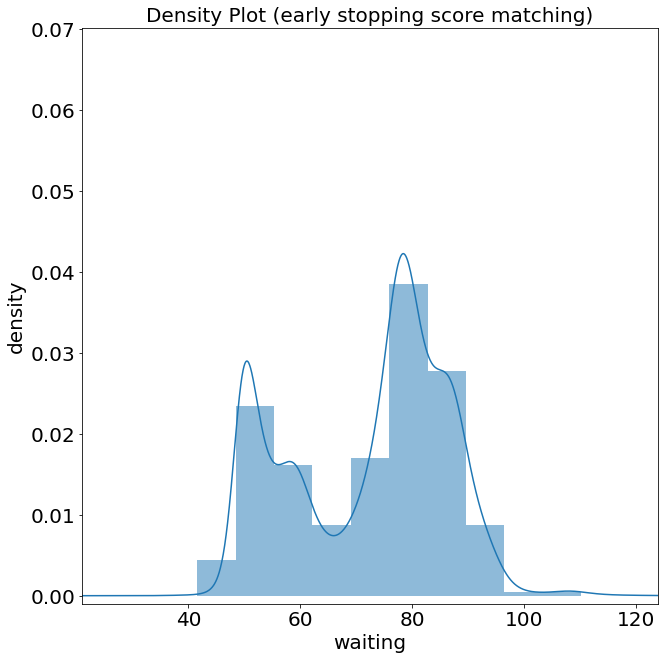

In [13]:
# specify the plotting parameters 
plot_params = plot_density_1d_params(xlimit, ylimit)

# visualize density estimate
den_vals = plot_density_1d(
    data = waiting, 
    kernel_function = kernel_function, 
    base_density = base_density, 
    basis_type = 'smbasis',
    coef = coef_smes, 
    normalizing = True, 
    method = 'early stopping score matching', 
    x_label = 'waiting',
    grid_points = None,
    save_plot = False, 
    save_dir = None, 
    save_filename = None, 
    plot_kwargs = plot_params)

Similar to the penalized score matching density estimation method, it is typical that the best number of iterations in the early stopping score matching density estimation method is unknown. With a list of candidates of numbers of iterations, we can use the cross validation to select the best one. The main function that achieves this is `optiter` in the class `ScoreMatchingEarlyStopping`, which returns the optimal number of iterations and the corresponding coefficient vector of basis functions in the natural parameter.

In [14]:
opt_smes = sm_earlystop.optiter(
    iternum_cand = [0, 2, 5, 10, 20, 50, 100, 200], 
    k_folds = 5, 
    step_size = 20, 
    save_dir = None, 
    save_info = False)

Iteration Number 0: 0
Iteration Number 1: 2
Iteration Number 2: 5
Iteration Number 3: 10
Iteration Number 4: 20
Iteration Number 5: 50
Iteration Number 6: 100
Iteration Number 7: 200
The cross validation scores are:
{0: 0.0, 2: -0.0023489971, 5: -0.0044230453, 10: -0.0059311923, 20: -0.0063764689, 50: -0.0052628953, 100: -0.0043754527, 200: -0.0036806235}
The optimal number of iterations is 20.
Final run with the optimal number of iterations.


The optimal number of iterations is {{opt_smes['opt_iter']}}. We now plot the corresponding density estimate below.

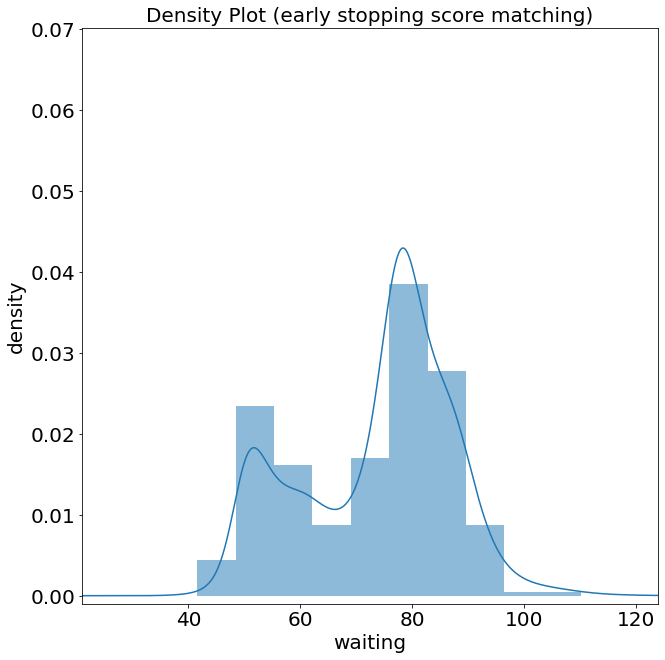

In [15]:
# visualize the optimal density estimate
den_vals = plot_density_1d(
    data = waiting, 
    kernel_function = kernel_function, 
    base_density = base_density, 
    basis_type = 'smbasis', 
    coef = opt_smes['opt_coef'], 
    normalizing = True, 
    method = 'early stopping score matching', 
    x_label = 'waiting',
    grid_points = None,
    save_plot = False, 
    save_dir = None, 
    save_filename = None, 
    plot_kwargs = plot_params)

## Negative Log-likelihood Density Estimation

We now switch to density estimation by minimizing the penalized negative log-likelihood loss function, or equivalently, maximizing the penalized log-likelihood function. In the `dekef` package, we provide two kinds of basis functions of the natural parameter in the resulting density estimate. 

The first kind of basis functions is those identical to the score matching density estimators, i.e.,  

$$\partial_1 k (X_i, \,\cdot\,) \, \text{ for all } i = 1, \cdots, n, \quad \text{ and } \quad \hat{z} := \frac{1}{n} \sum_{i=1}^n \big(\partial_1^2 k (X_i, \,\cdot\,) + (\log \mu)' (X_i) \partial_1 k (X_i, \,\cdot\,)\big),$$ 

where $X_1, \cdots, X_n$ are the training data, $\mu$ denotes the base density in the kernel exponential family, $\partial_1 k (x, \,\cdot\,)$ denotes the partial derivative of the kernel function $k$ with respect to the first argument. 

The second kind of basis functions is those proposed in [Gu and Qiu (1993)](https://projecteuclid.org/euclid.aos/1176349023) and [Gu (1993)](https://www.tandfonline.com/doi/abs/10.1080/01621459.1993.10476300), i.e., 

$$k (X_i, \,\cdot\,) \, \text{ for all } i = 1, \cdots, n.$$

Note that the basis functions above are particular to the 1-dimensional setting. If the data are $d$-dimensional, the basis functions of the natural parameter in score matching density estimators are 

$$\partial_u k (X_i, \,\cdot\,) \, \text{ for all } i = 1, \cdots, n \text{ and } u = 1, \cdots, d, \quad \text{ and } \quad \hat{z} := \frac{1}{n} \sum_{i=1}^n \sum_{u=1}^d \big(\partial_u^2 k (X_i, \,\cdot\,) + \partial_u \log \mu (X_i) \partial_u k (X_i, \,\cdot\,)\big),$$ 

where $\partial_u \log \mu$ is the partial derivative of $\log \mu$ with respect to its $u$-th coordinate, and $\partial_u k$ denotes the partial derivative of $k$ with respect to the $u$-th coordinate of its first argument. Notice that, in this kind of basis functions, there are always $n d + 1$ basis functions in total. 

However, in the $d$-dimensional setting, the basis functions proposed in [Gu and Qiu (1993)](https://projecteuclid.org/euclid.aos/1176349023) and [Gu (1993)](https://www.tandfonline.com/doi/abs/10.1080/01621459.1993.10476300) are still

$$k (X_i, \,\cdot\,) \, \text{ for all } i = 1, \cdots, n.$$


### Using basis functions of score matching density estimators

In order to estimate density functions using the penalized negative log-likelihood loss function at a single penalty parameter $\lambda > 0$ and using the basis functions that are identical to the score matching density estimators, we use the function `coef` in the class `NegLogLikSMBasis`, which yields the coefficients of basis functions in the natural parameter. 

In [16]:
# set parameters for computing the density estimate
bmc_params = batch_montecarlo_params(
    mc_batch_size = 5000, 
    mc_tol = 1e-2)

gdalgo_params = negloglik_optalgo_params(
    start_pt = np.zeros((waiting.shape[0] * waiting.shape[1] + 1, 1)), 
    step_size = 1.2, 
    max_iter = 50, 
    rel_tol = 1e-5, 
    abs_tol = 0.05)

In [17]:
nll_pen_smbasis = NegLogLikSMBasis(
    data = waiting, 
    base_density = base_density,
    kernel_type = 'gaussian_poly2', 
    kernel_r1 = 1.0, 
    kernel_r2 = 0.0, 
    kernel_c = 0.0, 
    kernel_bw = bw
)

In [18]:
np.random.seed(0)
coef_nll_pen_smbasis = nll_pen_smbasis.coef(
    data = waiting, 
    lambda_param = np.exp(-10.0), 
    optalgo_params = gdalgo_params, 
    batchmc_params = bmc_params, 
    batch_mc = True, 
    print_error = False)

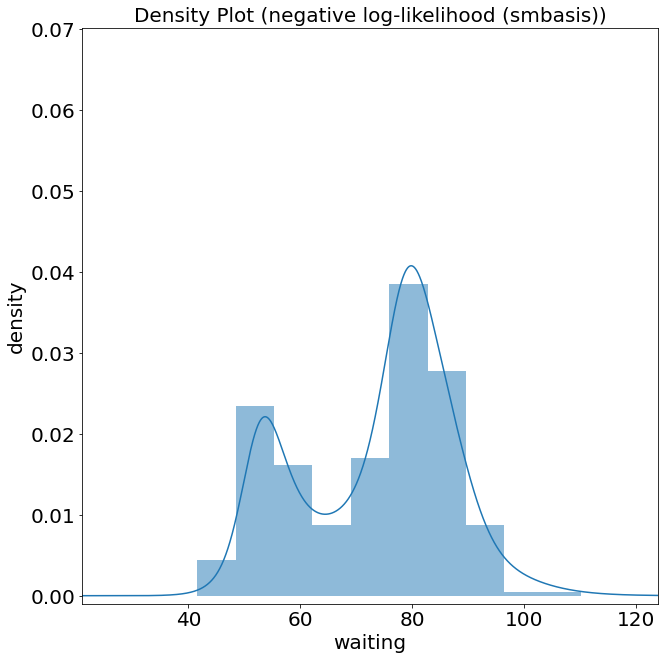

In [19]:
# specify the plotting parameters 
plot_params = plot_density_1d_params(xlimit, ylimit)

# visualize density estimate
den_vals = plot_density_1d(
    data = waiting, 
    kernel_function = kernel_function, 
    base_density = base_density, 
    basis_type = 'smbasis', 
    coef = coef_nll_pen_smbasis, 
    normalizing = True, 
    method = 'negative log-likelihood (smbasis)', 
    x_label = 'waiting',
    grid_points = None, 
    save_plot = False, 
    save_dir = None, 
    save_filename = None, 
    plot_kwargs = plot_params)

### Using basis functions proposed in Gu and Qiu (1993) and Gu (1993)

On the other hand, in order to estimate density functions using the penalized negative log-likelihood loss function at a single penalty parameter $\lambda > 0$ and using the basis functions proposed in [Gu and Qiu (1993)](https://projecteuclid.org/euclid.aos/1176349023) and [Gu (1993)](https://www.tandfonline.com/doi/abs/10.1080/01621459.1993.10476300), we use the function `coef` in the class `NegLogLikGuBasis`, which yields the coefficients of basis functions in the natural parameter. 

In [20]:
# set parameters for computing the density estimate
batchmc_params = batch_montecarlo_params(
    mc_batch_size = 1000, 
    mc_tol = 1e-2)

nll_algo_params = negloglik_optalgo_params(
    start_pt = np.zeros((waiting.shape[0], 1)), 
    step_size = 0.03, 
    max_iter = 100, 
    rel_tol = 1e-2, 
    abs_tol = 0.1
)

In [21]:
# Here, we choose the penalty parameter to be exp(-5.0), supplied using the lambda_param argument. 
nll_pen_gubasis = NegLogLikGuBasis(
    data = waiting, 
    base_density = base_density, 
    kernel_type = 'gaussian_poly2',
    kernel_r1 = 1.0, 
    kernel_r2 = 0.0, 
    kernel_c = 0.0, 
    kernel_bw = bw
)

In [22]:
np.random.seed(0)
coef_nll_pen_gubasis = nll_pen_gubasis.coef(
    data = waiting, 
    lambda_param = np.exp(-9.0), 
    optalgo_params = nll_algo_params, 
    batchmc_params = batchmc_params, 
    batch_mc = True, 
    print_error = False)

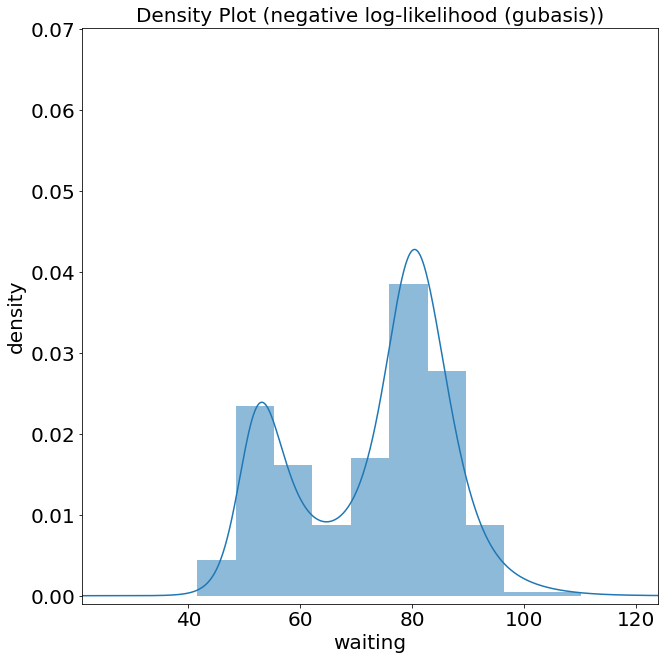

In [23]:
# specify the plotting parameters 
plot_params = plot_density_1d_params(xlimit, ylimit)

# visualize density estimate
den_vals = plot_density_1d(
    data = waiting, 
    kernel_function = kernel_function, 
    base_density = base_density, 
    basis_type = 'gubasis', 
    coef = coef_nll_pen_gubasis, 
    normalizing = True, 
    method = 'negative log-likelihood (gubasis)', 
    x_label = 'waiting',
    grid_points = None,
    save_plot = False, 
    save_dir = None, 
    save_filename = None, 
    plot_kwargs = plot_params)